# State of the Problem 2: EFFECTS OF URBANIZATION & POPULATION FACTORS TO DENGUE CASES

## PYTHON TOOLS NEEDED

In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from sklearn.metrics import mean_squared_error, r2_score
import math
import matplotlib.pyplot as plt

## SEIR MODEL

In [2]:
# 1. Model with Urbanization Factors
def seir_with_urbanization(y, t, beta_0, sigma, gamma, urbanization_rate, population_density):
    S_h, E_h, I_h, R_h = y
    N = S_h + E_h+ I_h + R_h

    beta = beta_0 * (1 + 0.05 * urbanization_rate[int(t)]) * (1 + 0.05 * population_density[int(t)])

    # SEIR (Human) equations
    dS_hdt = -beta * S_h * I_h / N
    dE_hdt = (beta * S_h * I_h / N) - (sigma * E_h)
    dI_hdt = (sigma * E_h) - (gamma * I_h)
    dR_hdt = gamma * I_h

    return [dS_hdt, dE_hdt, dI_hdt, dR_hdt]

In [3]:
# 2. Model without Urbanization Factors
def standar_seir(y, t, beta_0, sigma, gamma):
    S_h, E_h, I_h, R_h = y
    N = S_h + E_h + I_h + R_h

    # Constant transmission rate
    beta = beta_0

    # SEIR (Human) equations
    dS_hdt = -beta * S_h * I_h / N
    dE_hdt = (beta * S_h * I_h / N) - (sigma * E_h)
    dI_hdt = (sigma * E_h) - (gamma * I_h)
    dR_hdt = gamma * I_h

    return [dS_hdt, dE_hdt, dI_hdt, dR_hdt]

## ACCURACY EVALUATION CALCULATION

In [4]:
# Function to evaluate model accuracy
def evaluate_model(y_true, y_pred):
    """Calculates RMSE and R-squared."""
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    r_squared = r2_score(y_true, y_pred)
    return rmse, r_squared

## SIMULATION AND EVALUATION

In [5]:
dengue_cases = pd.read_csv('cleaned_dengue_data.csv')

# Example Data and Parameters
N = dengue_cases['Total_Population'].iloc[-1]   # Total population
I0 = dengue_cases['New_cases'].iloc[-1]         # Initial infected cases
E0 = 0                                          # Initial exposed cases
R0 = dengue_cases['Total_cases'].iloc[-1]       # Initial recovered cases
S0 = N - I0 - E0 - R0 # Initial susceptible population

y0 = [S0, E0, I0, R0]

# SEIR model parameters
sigma = 1/5     # Incubation rate (1/incubation period, e.g., 5 days)
gamma = 1/10    # Recovery rate (1/infectious period, e.g., 10 days)
beta = 1/7      # Infection rate (1/exposed period, e.g., 7 days)

# Time array for a 90-day simulation
time_array = np.arange(0, 90)

# querying data for First Quarter (Jan, Feb, March)
first_quarter_data = dengue_cases.query('Month_Num == 1 | Month_Num == 2 | Month_Num == 3') 

# average Urbanization_Rate rate for 1st quarter
jan_urbanization = first_quarter_data.query('Month_Num == 1')['Urbanization_Rate'].mean()       # average Urbanization_Rate for January
feb_urbanization = first_quarter_data.query('Month_Num == 2')['Urbanization_Rate'].mean()       # average Urbanization_Rate for February
mar_urbanization = first_quarter_data.query('Month_Num == 3')['Urbanization_Rate'].mean()       # average Urbanization_Rate for March

# average Population_Density for 1st quarter
jan_population = first_quarter_data.query('Month_Num == 1')['Population_Density'].mean()    # average Population_Density for January
feb_population = first_quarter_data.query('Month_Num == 2')['Population_Density'].mean()    # average Population_Density for February
mar_population = first_quarter_data.query('Month_Num == 3')['Population_Density'].mean()    # average Population_Density for March

monthly_ave_urbanization = [jan_urbanization, feb_urbanization, mar_urbanization]
monthly_ave_population = [jan_population, feb_population, mar_population]

# Create empty lists to store daily data
urbanization_rate = []
population_density = []
humidity_daily = []

# Populate the daily lists by repeating each month's average for 30 days
days_in_month = 30
for i in range(len(monthly_ave_population)):
    urbanization_rate.extend([monthly_ave_population[i]] * days_in_month)
    population_density.extend([monthly_ave_urbanization[i]] * days_in_month)

### Simulation 1: SEIR forecast with Urbanization Data

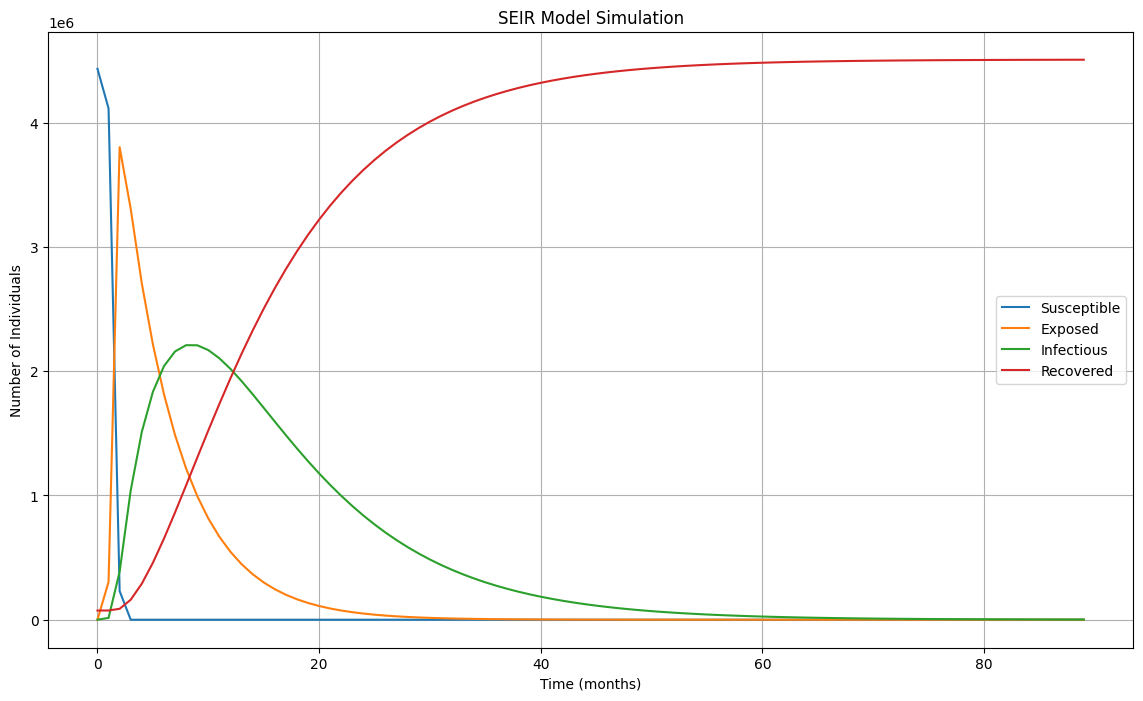

In [6]:
solution_urban = odeint(seir_with_urbanization, y0, time_array, args=(beta, sigma, gamma, urbanization_rate, population_density))
simulated_cases_urban = solution_urban[:, 2] # Index 2 is the 'I' (Infected) compartment

S, E, I, R = solution_urban.T # Transpose the solution to get S, E, I, R as separate arrays
SEIR = pd.DataFrame({
    'S': S,
    'E': E,
    'I': I,
    'R': R
})
# SEIR.to_csv('seir-forecast.csv', mode='w', index=False)

# --- Plot the Results ---
plt.figure(figsize=(14, 8))
plt.plot(time_array, S, label='Susceptible')
plt.plot(time_array, E, label='Exposed')
plt.plot(time_array, I, label='Infectious')
plt.plot(time_array, R, label='Recovered')
plt.xlabel('Time (months)')
plt.ylabel('Number of Individuals')
plt.title('SEIR Model Simulation')
plt.legend()
plt.grid(True)
plt.show()

### Simulation 2: Standard SEIR forecast 

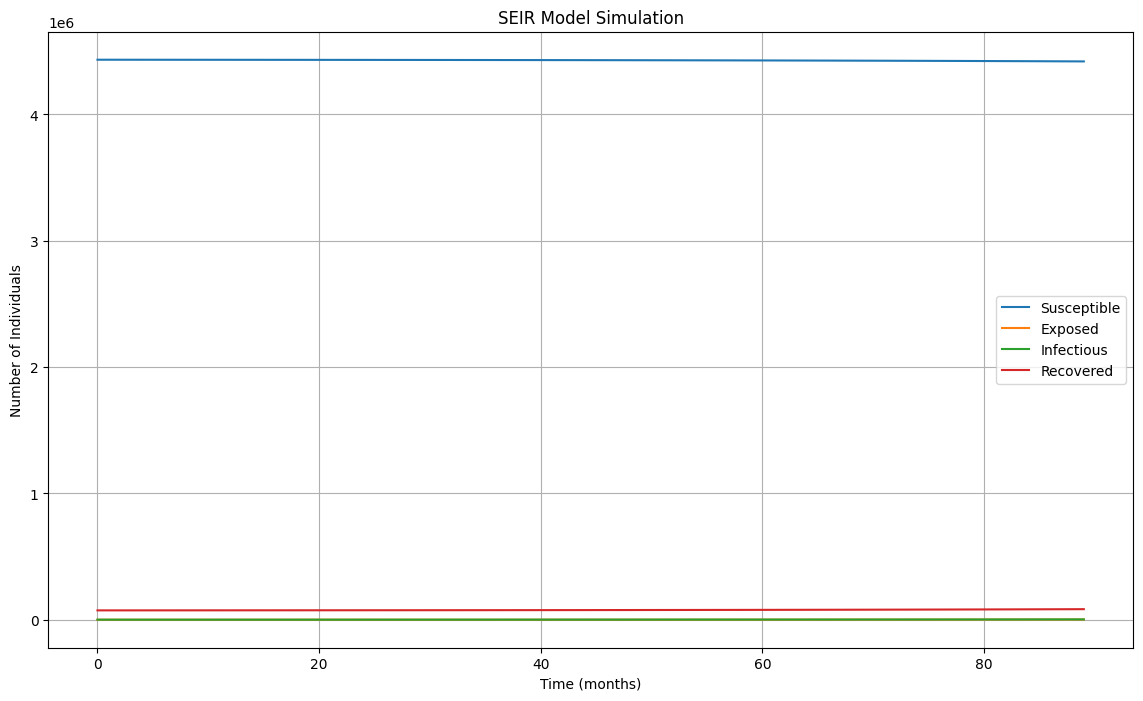

In [7]:
# 2. Run the simulation without Urbanization factors
solution_no_meteo = odeint(standar_seir, y0, time_array, args=(beta, sigma, gamma))
simulated_cases_no_urban = solution_no_meteo[:, 2]

S, E, I, R = solution_no_meteo.T # Transpose the solution to get S, E, I, R as separate arrays
SEIR = pd.DataFrame({
    'S': S,
    'E': E,
    'I': I,
    'R': R
})
# SEIR.to_csv('seir-forecast.csv', mode='w', index=False)

# --- Plot the Results ---
plt.figure(figsize=(14, 8))
plt.plot(time_array, S, label='Susceptible')
plt.plot(time_array, E, label='Exposed')
plt.plot(time_array, I, label='Infectious')
plt.plot(time_array, R, label='Recovered')
plt.xlabel('Time (months)')
plt.ylabel('Number of Individuals')
plt.title('SEIR Model Simulation')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
# Observed data (using our actual data from the past `t` days)
observed_cases = dengue_cases['New_cases'].tail(len(time_array)).values

## STATISTICAL ANALYSIS AND COMPARISON

In [9]:
# Evaluate the model with Urbanization factors
rmse_meteo, r2_meteo = evaluate_model(observed_cases, simulated_cases_urban)
print(f"Model WITH Urbanization Factors:")
print(f"  RMSE: {rmse_meteo:.2f}")
print(f"  R-squared: {r2_meteo:.2f}")

print("-" * 30)

# Evaluate the model without Urbanization factors
rmse_no_meteo, r2_no_meteo = evaluate_model(observed_cases, simulated_cases_no_urban)
print(f"Model WITHOUT Urbanization Factors:")
print(f"  RMSE: {rmse_no_meteo:.2f}")
print(f"  R-squared: {r2_no_meteo:.2f}")

# SOP 1: Comparison
print("-" * 30)
if rmse_meteo < rmse_no_meteo and r2_meteo > r2_no_meteo:
    print("Conclusion: Including Urbanization factors IMPROVES forecast accuracy.")
    print("The factors have a significant effect on dengue transmission.")
else:
    print("Conclusion: Including Urbanization factors does NOT improve forecast accuracy.")
    print("The factors may not have a significant effect, or the model's formulation needs adjustment.")

Model WITH Urbanization Factors:
  RMSE: 851910.32
  R-squared: -1119616.69
------------------------------
Model WITHOUT Urbanization Factors:
  RMSE: 1213.77
  R-squared: -1.27
------------------------------
Conclusion: Including Urbanization factors does NOT improve forecast accuracy.
The factors may not have a significant effect, or the model's formulation needs adjustment.
